In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Set the main directory path for the dataset
dataset_dir = "/kaggle/input/less-images/dataset_JUNTADO/train"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specify as training data
)

val_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify as validation data
)

# Model definition
base_model = DenseNet201(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x=Dense(512,activation="relu")(x)
x=Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=val_generator
)
model.save("densenet201_non11.h5")

# Plotting training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation and metrics
val_predictions = model.predict(val_generator)
val_predictions = np.round(val_predictions).flatten()
val_true_labels = val_generator.classes
f1 = f1_score(val_true_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_true_labels, val_predictions).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("F1 Score:", f1)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the saved model
model_path = "/kaggle/input/non11-densnet/densenet201_non11_.h5"
model = load_model(model_path)

# Path to the test dataset
test_folder = "/kaggle/input/less-images/dataset_JUNTADO/test"

# Data generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Assuming no augmentation is needed for test data

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Adjust if it's not binary classification
    shuffle=False  # Ensure predictions are aligned with ground truth labels
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Make predictions on the test data
test_predictions = model.predict(test_generator)
test_predictions = np.round(test_predictions).flatten()

# Get true labels for the test data
test_true_labels = test_generator.classes

# Calculate F1 score, confusion matrix, and classification report
f1 = f1_score(test_true_labels, test_predictions)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions)

# Output the evaluation metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


2024-04-10 18:29:55.156925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 18:29:55.157162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 18:29:55.317370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4580 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.6931 - loss: 0.5760
144/144 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step
Test Loss: 0.7203869819641113
Test Accuracy: 0.6358078718185425
F1 Score: 0.5873330034636319
Confusion Matrix:
[[1725  640]
 [1028 1187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.67      2365
           1       0.65      0.54      0.59      2215

    accuracy                           0.64      4580
   macro avg       0.64      0.63      0.63      4580
weighted avg       0.64      0.64      0.63      4580



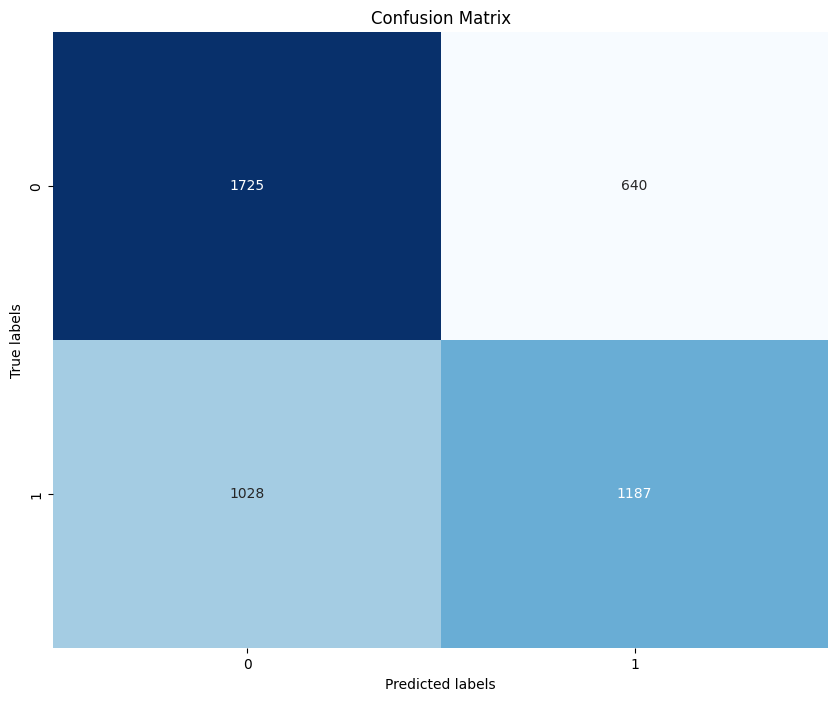

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model_path = "/kaggle/input/non11-densnet/densenet201_non11_.h5"
model = load_model(model_path)

# Path to the test dataset
test_folder = "/kaggle/input/less-images/dataset_JUNTADO/test"

# Data generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Assuming no augmentation is needed for test data

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Adjust if it's not binary classification
    shuffle=False  # Ensure predictions are aligned with ground truth labels
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Make predictions on the test data
test_predictions = model.predict(test_generator)
test_predictions = np.round(test_predictions).flatten()

# Get true labels for the test data
test_true_labels = test_generator.classes

# Calculate F1 score, confusion matrix, and classification report
f1 = f1_score(test_true_labels, test_predictions)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions)

# Output the evaluation metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot confusion matrix as an image
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


**RESNET-50**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

# Set the main directory path for the dataset
dataset_dir ="/kaggle/input/less-images/dataset_JUNTADO/train" 

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specify as training data
)

val_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify as validation data
)

# Model definition
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=val_generator
)
model.save("resnet50_non11.h5")

# Plotting training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation and metrics
val_predictions = model.predict(val_generator)
val_predictions = np.round(val_predictions).flatten()
val_true_labels = val_generator.classes
f1 = f1_score(val_true_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_true_labels, val_predictions).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("F1 Score:", f1)
print("Specificity:", specificity)
print("Sensitivity:",sensitivity)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

# Set the main directory path for the dataset
dataset_dir ="/kaggle/input/less-images/dataset_JUNTADO/train" 

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specify as training data
)

val_generator = train_datagen.flow_from_directory(
    directory=dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify as validation data
)

# Model definition
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=val_generator
)
model.save("vgg16_model.h5")

# Plotting training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation and metrics
val_predictions = model.predict(val_generator)
val_predictions = np.round(val_predictions).flatten()
val_true_labels = val_generator.classes
f1 = f1_score(val_true_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_true_labels, val_predictions).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("F1 Score:", f1)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model_path = "/kaggle/working/vgg16_model.h5"
model = load_model(model_path)

# Path to the test dataset
test_folder = "/kaggle/input/less-images/dataset_JUNTADO/test"

# Data generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Assuming no augmentation is needed for test data

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Adjust if it's not binary classification
    shuffle=False  # Ensure predictions are aligned with ground truth labels
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Make predictions on the test data
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels for the test data
test_true_labels = test_generator.classes

# Calculate F1 score, confusion matrix, and classification report
f1 = f1_score(test_true_labels, test_predictions)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions)

# Output the evaluation metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)